# NASA DEM

In [1]:
from IPython.display import display_markdown

display_markdown(open("README.md").read(), raw=True)

# NASADEM

This dataset contains an extract of the [NASADEM product](https://lpdaac.usgs.gov/news/release-nasadem-data-products/) for the San Diego MSA. NASADEM provides a digital elevation model for the world.

- `Source`: NASA EarthData
- `URL`

> [https://lpdaac.usgs.gov/news/release-nasadem-data-products/](https://lpdaac.usgs.gov/news/release-nasadem-data-products/)

- `Processing`: acquisition and transformation of the dataset are documented in `build_nasadem_sd.ipynb`


## Build the `nasadem_sd` extract

This notebook documents the acquisition and extraction of the San Diego region from the global [NASADEM dataset](https://lpdaac.usgs.gov/news/release-nasadem-data-products/).

In [1]:
%matplotlib inline

import zipfile
import cenpy
import contextily as cx
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt

## Data acquisition

We use the `NASADEM_HGT` variant of the project. We select the areas to download through the [NASA EarthData Search](https://search.earthdata.nasa.gov/search) tool. Once selected, the extract requires the following files:

In [2]:
base_url = ("https://e4ftl01.cr.usgs.gov//"\
            "MODV6_Dal_G/MEASURES/NASADEM_HGT.001/"\
            "2000.02.11/"
           )
f_urls = ["NASADEM_HGT_n33w118.zip",
          "NASADEM_HGT_n33w117.zip",
          "NASADEM_HGT_n32w117.zip",
          "NASADEM_HGT_n32w118.zip"
         ]
for url in f_urls:
    print(base_url + url)

https://e4ftl01.cr.usgs.gov//MODV6_Dal_G/MEASURES/NASADEM_HGT.001/2000.02.11/NASADEM_HGT_n33w118.zip
https://e4ftl01.cr.usgs.gov//MODV6_Dal_G/MEASURES/NASADEM_HGT.001/2000.02.11/NASADEM_HGT_n33w117.zip
https://e4ftl01.cr.usgs.gov//MODV6_Dal_G/MEASURES/NASADEM_HGT.001/2000.02.11/NASADEM_HGT_n32w117.zip
https://e4ftl01.cr.usgs.gov//MODV6_Dal_G/MEASURES/NASADEM_HGT.001/2000.02.11/NASADEM_HGT_n32w118.zip


Download is free but requires a login from the USGS. We assume the four files have been downloaded and placed in the same folder as this notebook.

Next is extracting the DEM files (`.hgt`) and merging them into a single `.tif` for convenience. `.tif` is a common file format for rasters that will make it handier later on to work with the merged file to clip it.

- Extraction of `.hgt` files

In [3]:
for zipped in f_urls:
    zip_f = zipfile.ZipFile(zipped, "r")
    f = zipped.strip("NASADEM_HGT_").strip(".zip")
    zip_f.extract(f+".hgt")
    zip_f.close()

- Merging into a single `.tif` file

In [4]:
! rio merge -f GTIFF *.hgt merged.tif
! rm *.hgt

proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
Error: Could not open file : file exists and won't be overwrit

## Extraction of SD region

* Region boundaries

Let's pull out total population (`P001001`):

In [5]:
%%time
census10 = cenpy.products.Decennial2010()
sd = census10.from_msa("San Diego, CA",
                       level="county",
                       variables=["P001001"]
                      )\
             .to_crs(epsg=4326)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 2.61 s, sys: 121 ms, total: 2.73 s
Wall time: 54.4 s


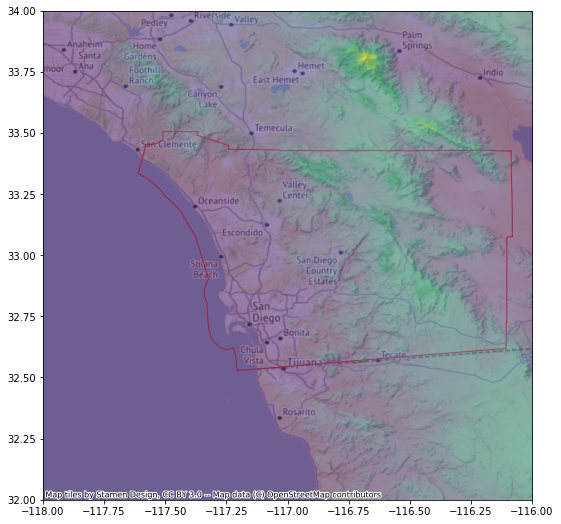

In [6]:
r = rasterio.open("merged.tif")

f, ax = plt.subplots(1, figsize=(9, 9))
sd.plot(facecolor="none", edgecolor="#F93822", zorder=1, ax=ax)
ax = rioshow(r, alpha=0.5, zorder=2, ax=ax)
cx.add_basemap(ax, crs=r.crs)

In [7]:
sd.to_file("sd.geojson", driver="GeoJSON")

* Clipping of DEM for SD

In [8]:
! rio mask merged.tif \
           nasadem_sd.tif \
           --crop \
           --geojson-mask\
           sd.geojson
! rm merged.tif sd.geojson

proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: Open of /opt/conda/share/proj failed
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
Error: Could not open file : file exists and won't be overwritten without use of the `--overwrite` option.


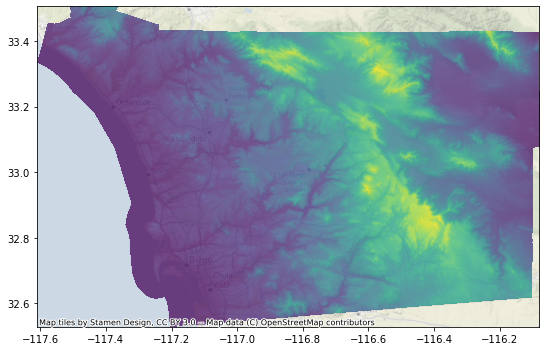

In [9]:
f, ax = plt.subplots(1, figsize=(9, 9))
r = rasterio.open("nasadem_sd.tif")
rioshow(r, zorder=1, alpha=0.75, ax=ax)
cx.add_basemap(ax, alpha=0.5, crs=r.crs)

---

## Download link

{download}`[Download the *nasadem_sd.tif* file] <./nasadem_sd.tif>`
